In [36]:
import hydrofunctions as hf
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pickle5
import requests
import warnings
import numpy as np
from pandas.tseries.frequencies import to_offset
import logging
import matplotlib
%matplotlib inline
import matplotlib.gridspec as gridspec
import hydrofunctions as hf
from hs_restclient import HydroShare, HydroShareAuthBasic
RID = '01cc3d5ad1a94331926d4a85553ecad2'

In [29]:
# this block is code for HydroFunctions package. I made a pull request to fix bugs, but it's not committed to 
# master yet. This code and the block below allow all users to run this notebook in the meantime

class HydroException(Exception):
    """
        This is the base class for all exceptions created for the
        HydroFunctions package. This class is not meant to be raised.
    """

    pass

class HydroNoDataError(HydroException):
    """Raised when a service returns an empty dataset or indicates that\
        it has no data for the request.
        **Usage**::
            raise HydroNoDataError("The NWIS service had no data for this request.")
        Do not catch this error for interactive sessions: The user should
        get a useful message from the error when they try to request something
        that doesn't exist.
        Catch this error in automated systems so that the system can reconsider
        the request and either fix the request or move on to the next
        request.
        **Example**::
            try:
                hf.NWIS('666666666')
            except HydroNoDataError as err:
                print("This is just to illustrate how to capture this error.")
                print(err)
    """

    pass


"""
hydrofunctions.exceptions
~~~~~~~~~~~~~~~~~~~~~~~~~
This module contains all of the custom exceptions defined in this package. The
base class is HydroException and all custom exceptions are subclasses of
HydroException.
Use the errors like this::
    try:
        #some code here that might return no data
        #more code that might get encoded improperly
    except HydroNoDataError('This site has no data'):
        # handle error here.
    except HydroEncodeError():
        # handle this error here.
    else:
        # code to complete if there is no exception raised.
    finally:
        # code that you want to run whether an exception is raised or not.
        # If an exception wasn't caught, then this code gets run, and the
        # exception gets re-raised after this finally clause gets run.
Keep the try clause short: if you put too many things in there, it can be
difficult to figure out what broke. On the other hand, like in my example
above, it is more readable if you group a series of statements and then
handle their exceptions together.
**Example:**
    >>> raise HydroNoDataError("Oh no, NWIS doesn't have this data for you!")
https://axialcorps.com/2013/08/29/5-simple-rules-for-building-great-python-packages/
-----
"""
from __future__ import absolute_import, print_function, division, unicode_literals
import warnings


class HydroException(Exception):
    """
        This is the base class for all exceptions created for the
        HydroFunctions package. This class is not meant to be raised.
    """

    pass


class HydroNoDataError(HydroException):
    """Raised when a service returns an empty dataset or indicates that\
        it has no data for the request.
        **Usage**::
            raise HydroNoDataError("The NWIS service had no data for this request.")
        Do not catch this error for interactive sessions: The user should
        get a useful message from the error when they try to request something
        that doesn't exist.
        Catch this error in automated systems so that the system can reconsider
        the request and either fix the request or move on to the next
        request.
        **Example**::
            try:
                hf.NWIS('666666666')
            except HydroNoDataError as err:
                print("This is just to illustrate how to capture this error.")
                print(err)
    """

    pass


class HydroEncodeError(HydroException):
    """Raised when an error occurs while encoding or decoding an argument.
        **Example**::
            try:
                # bunch of code from your package
            except HydroException:
                # blanked condition to handle all errors from your package
    """

    pass


class HydroUserWarning(UserWarning):
    """Warn user of a hazardous condition or when an action has been triggered\
        that may be unexpected.
        This is the base class for all warnings created for the HydroFunctions
        package. This class can be used if there is no more specific warning
        available.
        **Usage**::
            import warnings
            ... code
            warnings.warn('This is my warning message.', HydroUserWarning)
        Note:
            Warnings can be hidden or turned off depending on how the user is
            accessing Python and the settings for their interface.
            Use HydroException if a process must be shut down, or is doomed to
            fail anyway. This will at least give the user a helpful error
            message.
    """

    pass

In [30]:
def get_nwis(
    site,
    service="dv",
    start_date=None,
    end_date=None,
    stateCd=None,
    countyCd=None,
    bBox=None,
    parameterCd="all",
    period=None,
):
    """Request stream gauge data from the USGS NWIS.
    Args:
        site (str or list of strings):
            a valid site is '01585200' or ['01585200', '01646502']. site
            should be `None` if stateCd or countyCd are not `None`.
        service (str):
            can either be 'iv' or 'dv' for instantaneous or daily data.
                - 'dv'(default): daily values. Mean value for an entire day.
                - 'iv': instantaneous value measured at this time. Also known\
                    as 'Real-time data'. Can be measured as often as every\
                    five minutes by the USGS. 15 minutes is more typical.
        start_date (str):
           should take on the form yyyy-mm-dd
        end_date (str):
            should take on the form yyyy-mm-dd
        stateCd (str):
            a valid two-letter state postal abbreviation. Default is `None`.
        countyCd (str or list of strings):
            a valid county abbreviation. Default is `None`.
        bBox (str, list, or tuple):
            a set of coordinates that defines a bounding box.
                * Coordinates are in decimal degrees
                * Longitude values are negative (west of the prime meridian).
                * Latitude values are positive (north of the equator).
                * comma-delimited, no spaces, if provided as a string.
                * The order of the boundaries should be: "West,South,East,North"
                * Example: "-83.000000,36.500000,-81.000000,38.500000"
        parameterCd (str or list of strings):
            NWIS parameter code. Usually a five digit code. Default is 'all'.\
            A valid code can also be given as a list: ``parameterCd=['00060','00065']``
                * if value of 'all' is submitted, then NWIS will return every \
                    parameter collected at this site. (default option)
                * stage: '00065'
                * discharge: '00060'
                * not all sites collect all parameters!
                * See https://nwis.waterdata.usgs.gov/usa/nwis/pmcodes for full list
        period (str):
            NWIS period code. Default is `None`.
                * Format is "PxxD", where xx is the number of days before today.
                * Either use start_date or period, but not both.
    Returns:
        a response object. This function will always return the response,
            even if the NWIS returns a status_code that indicates a problem.
            * response.url: the url we used to request data
            * response.json: the content translated as json
            * response.status_code: the internet status code
                - '200': is a good request
                - non-200 codes will be reported as a warning.
                - '400': is a 'Bad Request'-- the parameters did not make sense
                - see <https://www.w3.org/Protocols/rfc2616/rfc2616-sec10.html> for more codes and meaning.
            * response.ok: `True` when we get a '200' status_code
    Raises:
        ConnectionError: due to connection problems like refused connection
            or DNS Error.
        SyntaxWarning: when NWIS returns a response code that is not 200.
    **Example:**
        >>> import hydrofunctions as hf
        >>> response = hf.get_nwis('01585200', 'dv', '2012-06-01', '2012-07-01')
        >>> response
        <response [200]>
        >>> response.json()
        *JSON ensues*
        >>> hf.extract_nwis_df(response)
        *a Pandas dataframe appears*
    Other Valid Ways to Make a Request::
        >>> sites = ['07180500', '03380475', '06926000'] # Request a list of sites.
        >>> service = 'iv'  # Request real-time data
        >>> days = 'P10D'  # Request the last 10 days.
        >>> stage = '00065' # Sites that collect discharge usually collect water depth too.
        >>> response2 = hf.get_nwis(sites, service, period=days, parameterCd=stage)
    Request Data By Location::
        >>> # Request the most recent daily data for every site in Maine
        >>> response3 = hf.get_nwis(None, 'dv', stateCd='ME')
        >>> response3
        <Response [200]>
    The specification for the USGS NWIS IV service is located here:
    http://waterservices.usgs.gov/rest/IV-Service.html
    """

    service = check_NWIS_service(service)

    if parameterCd == "all":
        parameterCd = None

    header = {"Accept-encoding": "gzip", "max-age": "120"}

    values = {
        # specify version of nwis json. Based on WaterML1.1
        # json,1.1 works; json%2C works; json1.1 DOES NOT WORK
        "format": "json,1.1",
        "sites": check_parameter_string(site, "site"),
        "stateCd": stateCd,
        "countyCd": check_parameter_string(countyCd, "county"),
        "bBox": check_NWIS_bBox(bBox),
        "parameterCd": check_parameter_string(parameterCd, "parameterCd"),
        "period": period,
        "startDT": start_date,
        "endDT": end_date,
    }

#     # Check that site selection parameters are exclusive!
#     total = count_number_of_truthy([site, stateCd, countyCd, bBox])
#     if total == 1:
#         pass
#     elif total > 1:
#         raise ValueError(
#             "Select sites using either site, stateCd, "
#             "countyCd, or bBox, but not more than one."
#         )
#     elif total < 1:
#         raise ValueError(
#             "Select sites using at least one of the following "
#             "arguments: site, stateCd, countyCd or bBox."
#         )

    # Check that time parameters are not both set.
    # If neither is set, then NWIS will return the most recent observation.
    if start_date and period:
        raise ValueError(
            "Use either start_date or period, or neither, " "but not both."
        )

    if not (start_date or period):
        # User didn't specify time; must be requesting most recent data.
        # See issue #49.
        pass

    url = "https://waterservices.usgs.gov/nwis/"
    url = url + service + "/?"
    response = requests.get(url, params=values, headers=header)
    print("Requested data from", response.url)
    # requests will raise a 'ConnectionError' if the connection is refused
    # or if we are disconnected from the internet.

    # .get_nwis() will always return the response.

    # Higher-level code that calls get_nwis() may decide to handle or
    # report status codes that indicate something went wrong.

    # Issue warnings for bad status codes
    nwis_custom_status_codes(response)
    if not response.text:
        raise HydroNoDataError(
            "The NWIS has returned an empty string for this request."
        )

    return response

def check_NWIS_service(input):
    """Checks that the service is valid: either 'iv' or 'dv'"""
    if input is None:
        return None
    if input == "iv" or input == "dv":
        return input
    else:
        raise TypeError(
            "The NWIS service type accepts 'dv' for daily values, "
            "or 'iv' for instantaneous values. Actual value: "
            "{}".format(input)
        )
        
def check_parameter_string(candidate, param):
    """Checks that a parameter is a string or a list of strings.
    """
    parameters = {
        "site": "NWIS station id(s) should be a string or list of strings,"
        + "often in the form of an eight digit number enclosed in quotes.",
        "parameterCd": "NWIS parameter codes are five-digit strings that specify "
        + "the parameter that is being measured at the site. Common "
        + "codes are '00060' for stream stage in feet, '00065' for "
        + "stream discharge in cubic feet per second, and '72019' for "
        + "groundwater levels. Not all sites collect data for all "
        + "parameters. See a complete list of physical parameters here: "
        + "https://help.waterdata.usgs.gov/parameter_cd?group_cd=PHY "
        + "You may request multiple parameters by submitting a comma-"
        + "delimited string of codes with no spaces, or by submitting "
        + "a list of codes, like this: parameterCd = '00065,00060' or "
        + "parameterCd = ['00065', '00060'] ",
        "county": "The NWIS county parameter accepts a five-digit string or "
        + "a list of five-digit strings to select all of the sites "
        + "within a county or list of counties. "
        + "Example: '51059' or ['51059', '51061'] are acceptable.",
        "state": "This parameter uses US two-letter postal codes "
        + "such as 'MD' for Maryland or 'AZ' for Arizona.",
        "default": "This parameter should be a string or a list of strings.",
    }
    if param in parameters:
        msg = parameters[param] + " Actual value: {}".format(candidate)
    else:
        msg = (
            "This parameter should be a string or a list of strings."
            + " Actual value: {}".format(candidate)
        )

    if candidate is None:
        return None
    elif isinstance(candidate, str) and candidate:
        return candidate
    elif (isinstance(candidate, list) or isinstance(candidate, tuple)) and candidate:
        for s in candidate:
            if not isinstance(s, str):
                raise TypeError(msg + "   bad element: {}".format(s))
        return ",".join([str(s) for s in candidate])
    else:
        raise TypeError(msg)
        
def check_NWIS_bBox(input):
    """Checks that the USGS bBox is valid.
    """
    msg = (
        "NWIS bBox should be a string, list of strings, or tuple "
        + "containing the longitude and latitude of the lower left corner "
        + "of the bounding box, followed by the longitude and latitude "
        + "of the upper right corner of the bounding box. Most often in "
        + 'the form of "ll_long,ll_lat,ur_long,ur_lat" . '
        + "All latitude and longitude values should have less than 8 "
        + "places. "
        + "Actual value: {}".format(input)
    )
    if input is None:
        return None
    # assume that if it is a string it will be fine as is.
    # don't accept a series of sites in a single string.
    # Test for and reject empty strings: empty strings are false.
    if isinstance(input, str) and input:
        t = input.split(",")
        if len(t) < 4:
            raise TypeError(msg)
        return input
    # test for input is a list and it is not empty
    elif (isinstance(input, list) or isinstance(input, tuple)) and input:
        if len(input) < 4:
            raise TypeError(msg)
        # format:  [-83.000000, 36.500000, -81.000000, 38.500000] ==> '-83.000000,36.500000,-81.000000,38.500000'
        return ",".join([str(s) for s in input])
    else:
        raise TypeError(msg)

def count_number_of_truthy(my_list):
    return sum(bool(item) for item in my_list)

def nwis_custom_status_codes(response):
    """
    Raise custom warning messages from the NWIS when it returns a
    status_code that is not 200.
    Args:
        response: a response object as returned by get_nwis().
    Returns:
        * `None`
            if response.status_code == 200
        * `response.status_code`
            for all other status codes.
    Raises:
        SyntaxWarning: when a non-200 status code is returned.
            https://en.wikipedia.org/wiki/List_of_HTTP_status_codes
    Note:
        To raise an exception, call ``response.raise_for_status()``
        This will raise `requests.exceptions.HTTPError` with a helpful message
        or it will return `None` for status code 200.
        From: http://docs.python-requests.org/en/master/user/quickstart/#response-status-codes
        NWIS status_code messages come from:
            https://waterservices.usgs.gov/docs/portable_code.html
        Additional status code documentation:
            https://waterservices.usgs.gov/rest/IV-Service.html#Error
    """
    nwis_msg = {
        "200": "OK",
        "400": "400 Bad Request - "
        "This often occurs if the URL arguments "
        "are inconsistent. For example, if you submit a request using "
        "a startDT and an endDT with the period argument. "
        "An accompanying error should describe why the request was "
        "bad." + "\nError message from NWIS: {}".format(response.reason),
        "403": "403 Access Forbidden - "
        "This should only occur if for some reason the USGS has "
        "blocked your Internet Protocol (IP) address from using "
        "the service. This can happen if we believe that your use "
        "of the service is so excessive that it is seriously "
        "impacting others using the service. To get unblocked, "
        "send us the URL you are using along with the IP using "
        "this form. We may require changes to your query and "
        "frequency of use in order to give you access to the "
        "service again.",
        "404": "404 Not Found - "
        "Returned if and only if the query expresses a combination "
        "of elements where data do not exist. For multi-site "
        "queries, if any data are found, it is returned for those "
        "site/parameters/date ranges where there are data.",
        "503": "500 Internal Server Error - "
        "If you see this, it means there is a problem with the web "
        "service itself. It usually means the application server "
        "is down unexpectedly. This could be caused by a host of "
        "conditions, but changing your query will not solve this "
        "problem. The NWIS application support team has to fix it. Most "
        "of these errors are quickly detected and the support team "
        "is notified if they occur.",
    }
    if response.status_code == 200:
        return None
    # All other status codes will raise a warning.
    else:
        # Use the status_code as a key, return None if key not in dict
        msg = (
            "The NWIS returned a code of {}.\n".format(response.status_code)
            + nwis_msg.get(str(response.status_code))
            + "\n\nURL used in this request: {}".format(response.url)
        )

        # Warnings will not beak the flow. They just print a message.
        # However, they are often supressed in some applications.
        warnings.warn(msg, SyntaxWarning)
        return response.status_code
    
def extract_nwis_df(nwis_dict, interpolate=True):
    """Returns a Pandas dataframe and a metadata dict from the NWIS response
    object or the json dict of the response.
    Args:
        nwis_dict (obj):
            the json from a response object as returned by get_nwis().json().
            Alternatively, you may supply the response object itself.
    Returns:
        a pandas dataframe.
    Raises:
        HydroNoDataError
            when the request is valid, but NWIS has no data for
            the parameters provided in the request.
        HydroUserWarning
            when one dataset is sampled at a lower frequency than
            another dataset in the same request.
    """
    if type(nwis_dict) is not dict:
        nwis_dict = nwis_dict.json()

    # strip header and all metadata.
    ts = nwis_dict["value"]["timeSeries"]
    if ts == []:
        # raise a HydroNoDataError if NWIS returns an empty set.
        #
        # Ideally, an empty set exception would be raised when the request
        # is first returned, but I do it here so that the data doesn't get
        # extracted twice.
        # TODO: raise this exception earlier??
        #
        # ** Interactive sessions should have an error raised.
        #
        # **Automated systems should catch these errors and deal with them.
        # In this case, if NWIS returns an empty set, then the request
        # needs to be reconsidered. The request was valid somehow, but
        # there is no data being collected.

        raise HydroNoDataError(
            "The NWIS reports that it does not " "have any data for this request."
        )

    # create a list of time series;
    # set the index, set the data types, replace NaNs, sort, find the first and last

    collection = []
    starts = []
    ends = []
    freqs = []
    meta = {}
    for series in ts:
        series_name = series["name"]
        temp_name = series_name.split(":")
        agency = str(temp_name[0])
        site_id = agency + ":" + str(temp_name[1])
        parameter_cd = str(temp_name[2])
        stat = str(temp_name[3])
        siteName = series["sourceInfo"]["siteName"]
        siteLatLongSrs = series["sourceInfo"]["geoLocation"]["geogLocation"]
        noDataValues = series["variable"]["noDataValue"]
        variableDescription = series["variable"]["variableDescription"]
        unit = series["variable"]["unit"]["unitCode"]
        data = series["values"][0]["value"]
        if data == []:
            # This parameter has no data. Skip to next series.
            continue
        if len(data) == 1:
            # This parameter only contains the most recent reading.
            # See Issue #49
            pass
        qualifiers = series_name + "_qualifiers"
        DF = pd.DataFrame(data=data)
        DF.index = pd.to_datetime(DF.pop("dateTime"), utc=True)
        DF["value"] = DF["value"].astype(float)
        DF = DF.replace(to_replace=noDataValues, value=np.nan)
        DF["qualifiers"] = DF["qualifiers"].apply(lambda x: ",".join(x))
        DF.rename(
            columns={"qualifiers": qualifiers, "value": series_name}, inplace=True
        )
        DF.sort_index(inplace=True)
        local_start = DF.index.min()
        local_end = DF.index.max()
        starts.append(local_start)
        ends.append(local_end)
        local_freq = calc_freq(DF.index)
        freqs.append(local_freq)
        if not DF.index.is_unique:
            print(
                "Series index for "
                + series_name
                + " is not unique. Attempting to drop identical rows."
            )
            DF = DF.drop_duplicates(keep="first")
            if not DF.index.is_unique:
                print(
                    "Series index for "
                    + series_name
                    + " is STILL not unique. Dropping first rows with duplicated date."
                )
                DF = DF[~DF.index.duplicated(keep="first")]
        if local_freq > to_offset("0min"):
            local_clean_index = pd.date_range(
                start=local_start, end=local_end, freq=local_freq, tz="UTC"
            )
            # if len(local_clean_index) != len(DF):
            # This condition happens quite frequently with missing data.
            # print(str(series_name) + "-- clean index length: "+ str(len(local_clean_index)) + " Series length: " + str(len(DF)))
            DF = DF.reindex(index=local_clean_index, copy=True)
        else:
            # The dataframe DF must contain only the most recent data.
            pass
        qual_cols = DF.columns.str.contains("_qualifiers")
        # https://stackoverflow.com/questions/21998354/pandas-wont-fillna-inplace
        # Instead, create a temporary dataframe, fillna, then copy back into original.
        DFquals = DF.loc[:, qual_cols].fillna("hf.missing")
        DF.loc[:, qual_cols] = DFquals

        if local_freq > pd.Timedelta(to_offset("0min")):
            variableFreq_str = str(to_offset(local_freq))
        else:
            variableFreq_str = str(to_offset("0min"))
        parameter_info = {
            "variableFreq": variableFreq_str,
            "variableUnit": unit,
            "variableDescription": variableDescription,
        }
        site_info = {
            "siteName": siteName,
            "siteLatLongSrs": siteLatLongSrs,
            "timeSeries": {},
        }
        # if site is not in meta keys, add it.
        if site_id not in meta:
            meta[site_id] = site_info
        # Add the variable info to the site dict.
        meta[site_id]["timeSeries"][parameter_cd] = parameter_info
        collection.append(DF)

    if len(collection) < 1:
        # It seems like this condition should not occur. The NWIS trims the
        # response and returns an empty nwis_dict['value']['timeSeries']
        # if none of the parameters requested have data.
        # If at least one of the paramters have data,
        # then the empty series will get delivered, but with no data.
        # Compare these requests:
        # empty:               https://nwis.waterservices.usgs.gov/nwis/iv/?format=json&sites=01570500&startDT=2018-06-01&endDT=2018-06-01&parameterCd=00045
        # one empty, one full: https://nwis.waterservices.usgs.gov/nwis/iv/?format=json&sites=01570500&startDT=2018-06-01&endDT=2018-06-01&parameterCd=00045,00060
        raise HydroNoDataError(
            "The NWIS does not have any data for"
            " the requested combination of sites"
            ", parameters, and dates."
        )
    startmin = min(starts)
    endmax = max(ends)
    # Remove all frequencies of zero from freqs list.
    zero = to_offset("0min")
    freqs2 = list(filter(lambda x: x > zero, freqs))
    if len(freqs2) > 0:
        freqmin = min(freqs2)
        freqmax = max(freqs2)
        if freqmin != freqmax:
            warnings.warn(
                "One or more datasets in this request is going to be "
                "'upsampled' to " + str(freqmin) + " because the data "
                "were collected at a lower frequency of " + str(freqmax),
                HydroUserWarning,
            )

        clean_index = pd.date_range(start=startmin, end=endmax, freq=freqmin, tz="UTC")
        cleanDF = pd.DataFrame(index=clean_index)
        for dataset in collection:
            cleanDF = pd.concat([cleanDF, dataset], axis=1)
        # Replace lines with missing _qualifier flags with hf.upsampled
        qual_cols = cleanDF.columns.str.contains("_qualifiers")
        cleanDFquals = cleanDF.loc[:, qual_cols].fillna("hf.upsampled")
        cleanDF.loc[:, qual_cols] = cleanDFquals
        if interpolate:
            # TODO: mark interpolated values with 'hf.interp'
            # select data, then replace Nans with interpolated values.
            data_cols = cleanDF.columns.str.contains(r"[0-9]$")
            cleanDFdata = cleanDF.loc[:, data_cols].interpolate()
            cleanDF.loc[:, data_cols] = cleanDFdata
    else:
        # If datasets only contain most recent data, then
        # don't set an index or a freq. Just concat all of the datasets.
        cleanDF = pd.concat(collection, axis=1)

    cleanDF.index.name = "datetimeUTC"

    if not DF.index.is_unique:
        DF = DF[~DF.index.duplicated(keep="first")]
    if not DF.index.is_monotonic:
        DF.sort_index(axis=0, inplace=True)

    return cleanDF, meta

def calc_freq(index):
    # Method 0: calc_freq() was called, but we haven't done anything yet.
    method = 0
    if isinstance(index, pd.DataFrame):
        index = index.index
    try:
        # Method 1: Try the direct approach first. Maybe freq has already been set.
        freq = index.freq
        method = 1
    except AttributeError:
        # index.freq does not exist, so let's keep trying.
        freq = None

    if freq is None:
        # Method 2: Use the built-in pd.infer_freq(). It raises ValueError
        #    when it fails, so catch ValueErrors and keep trying.
        try:
            freq = to_offset(pd.infer_freq(index))
            method = 2
        except ValueError:
            pass

    if freq is None:
        # Method 3: divide the length of time by the number of observations.
        freq = (index.max() - index.min()) / len(index)
        if pd.Timedelta("13 minutes") < freq < pd.Timedelta("17 minutes"):
            freq = to_offset("15min")
        elif pd.Timedelta("27 minutes") < freq < pd.Timedelta("33 minutes"):
            freq = to_offset("30min")
        elif pd.Timedelta("55 minutes") < freq < pd.Timedelta("65 minutes"):
            freq = to_offset("60min")
        else:
            freq = None
        method = 3

    if freq is None:
        # Method 4: Subtract two adjacent values and use the difference!
        if len(index) > 3:
            freq = to_offset(abs(index[2] - index[3]))
            method = 4
            logging.debug(
                "calc_freq4:"
                + str(freq)
                + "= index[2]:"
                + str(index[3])
                + "- index [3]:"
                + str(index[2])
            )

    if freq is None:
        # Method 5: If all else fails, freq is 0 minutes!
        warnings.warn(
            "It is not possible to determine the frequency "
            "for one of the datasets in this request. "
            "This dataset will be set to a frequency of "
            "0 minutes",
            HydroUserWarning,
        )

        freq = to_offset("0min")
        method = 5

    debug_msg = "Calc_freq method:" + str(method) + "freq:" + str(freq)
    logging.debug(debug_msg)
    return pd.Timedelta(freq)

In [ ]:
# put in hydroshare credentials if you don't have data yet
auth = HydroShareAuthBasic(username='username', password='password')
hs = HydroShare(auth=auth)

In [42]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

try:
    gagesII = gpd.read_file('../Data/bigfiles/gagesII_9322_point_shapefile/gagesII_9322_sept30_2011.shp')
except:
    dname = 'gagesII_9322_point_shapefile'
    try:
        os.mkdir('../Data/bigfiles')
    except:
        print('bigfiles directory exists')
    try:
        os.mkdir('../Data/bigfiles/'+dname)
    except:
        print('data dir exists')
    folder_contents_json = hs.getResourceFolderContents(RID, pathname=dname)
    for f in folder_contents_json['files']:
        if f[-3:]!='xml':
            fpath = hs.getResourceFile(RID, dname+'/'+f, destination='../Data/bigfiles')

    gagesII = gpd.read_file('../Data/bigfiles/gagesII_9322_point_shapefile/gagesII_9322_sept30_2011.shp')

bigfiles directory exists
data dir exists


In [ ]:
# # find all sites in US with longterm streamflow and temperature (15+ temperature and in GAGES II dataset)
# # candidate_sites = []

# for k in range(5,len(states)):
#     state = states[k]
#     print(k, state)

#     state_data = get_nwis(site=None,stateCd=state, service='dv', start_date='1950-01-01', end_date='2021-04-01',
#                     parameterCd = '00010')
#     state_data = extract_nwis_df(state_data)
#     state_data_meta = state_data[1]
#     state_data = state_data[0]
#     col_noqual = list(state_data.columns)
#     col_noqual = [j for j in col_noqual if j[-10:]!='qualifiers']
#     sitedict = {site: len(state_data[~(state_data[site].isna())]) for site in col_noqual}
#     goodsite_temp = [site for site in sitedict.keys() if sitedict[site]>365*15]
#     goodsite_temp = [site[5:-12] for site in goodsite_temp]
#     goodsite_temp = list(dict.fromkeys(goodsite_temp))
#     goodsite_temp = [int(site) for site in goodsite_temp]
#     goodsite = [site for site in goodsite_temp if site in gagesII.STAID.astype('int').values]
#     candidate_sites = candidate_sites + goodsite
#     print('number of sites in '+state+':',len(goodsite))
#     with open('../Data/gagesII_data_and_subsets/candidate_site_list.pkl', 'wb') as handle:
#         pickle5.dump(candidate_sites, handle, protocol=pickle5.HIGHEST_PROTOCOL)

In [3]:
with open('../Data/gagesII_data_and_subsets/candidate_site_list.pkl', 'rb') as f:
    candidate_sites = pickle5.load(f)
print('number of candidate sites:',len(candidate_sites))

number of candidate sites: 1434


In [4]:
gagesII_withtemp = gagesII[gagesII.STAID.astype('int').isin(candidate_sites)]
gagesII_withtemp.to_csv('../Data/gagesII_data_and_subsets/gagesII_15yr_temperature.csv',index=False)

In [5]:
state_outline = gpd.read_file('../Data/maps_and_boundaries/US_state_outline/cb_2018_us_state_500k.shp').to_crs(epsg=4326)

(-180.0, -152.0, 18.0, 30.0)

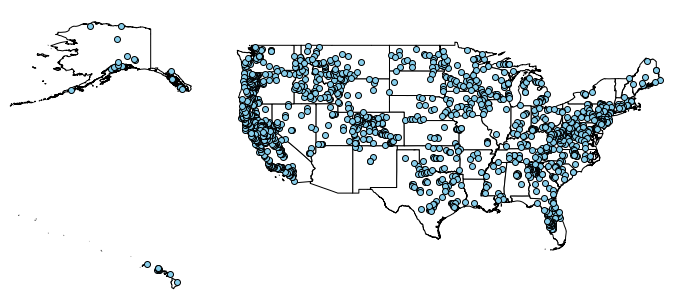

In [6]:
fig,ax = plt.subplots(1,figsize = (12,7))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,2.5]) 
gs.update(hspace=0.0)
gs.update(wspace=0.0)
ax0 = plt.subplot(gs[:,1])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])

ax = ax0
state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.scatter(gagesII_withtemp.LNG_GAGE.values, gagesII_withtemp.LAT_GAGE.values,edgecolor='k',
          c='skyblue')
ax.set_xlim(-130,-65)
ax.set_ylim(22,50)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = ax1
state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.scatter(gagesII_withtemp.LNG_GAGE.values, gagesII_withtemp.LAT_GAGE.values,edgecolor='k',
          c='skyblue')
ax.set_xlim(-180,-128)
ax.set_ylim(50,75)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = ax2
state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.scatter(gagesII_withtemp.LNG_GAGE.values, gagesII_withtemp.LAT_GAGE.values,edgecolor='k',
          c='skyblue')
ax.set_xlim(-180,-152)
ax.set_ylim(18,30)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

In [ ]:
# from this gauge list, how many gauges have 15 years of continuous data , not just 15 years of data
continuous_data_length = []

for i in range(len(candidate_sites)):
    print(i)
    site = str(candidate_sites[i])
    if len(site)<8:
        site = '0'+site
    try:
        state_data = get_nwis(site=site, service='dv', start_date='1950-01-01', end_date='2021-04-01',
                    parameterCd = '00010')
        state_data = extract_nwis_df(state_data)
        state_data_meta = state_data[1]
        state_data = state_data[0]

        try:
            coldata = state_data[state_data.columns[2]]
        except:
            coldata = state_data[state_data.columns[0]]
        coldata_mono = coldata.diff()>=0
        coldata_mono = coldata_mono.to_frame()
        coldata_mono['cluster'] = np.where(coldata_mono,0,1)
        a_list = coldata_mono['cluster'].values

        output = [idx for idx in range(len(a_list)-30) if 
                  all(a_list[idx+j]==a_list[idx] for j in range(29))]
        badindex = [j+i for i in range(30) for j in output]
        state_data = state_data.reset_index().drop(badindex,axis='index').set_index('datetimeUTC')
        state_data['skipvals'] = state_data.index.to_series().diff() > pd.Timedelta('120D')
        state_data['group_no'] = (state_data.skipvals).cumsum()
        grouplen = []
        for group in range(state_data.group_no.values[-1]+1):
            groupdata = state_data[state_data.group_no==group]
            grouplength = groupdata.index.values[-1]-groupdata.index.values[0]
            grouplen.append(pd.Timedelta(grouplength).days/365)

        print('max data length:',np.nanmax(grouplen),'years')
        continuous_data_length.append(np.nanmax(grouplen))

        state_data.drop(columns='group_no').plot(figsize = (15,4))
        plt.show()
    except:
        print('no data')
        continuous_data_length.append(np.nan)

In [8]:
record_length = {'site':candidate_sites, 'record_length_yr':continuous_data_length}
record_length = pd.DataFrame.from_dict(record_length)

In [ ]:
record_length.to_csv('../Data/gagesII_data_and_subsets/record_length_yrs.csv',index=False)

In [9]:
record_length = pd.read_csv('../Data/gagesII_data_and_subsets/record_length_yrs.csv')
gagesII_long15 = gagesII[gagesII.STAID.astype('int').isin(record_length[record_length.record_length_yr>=15].site)]
gagesII_long10 = gagesII[gagesII.STAID.astype('int').isin(record_length[record_length.record_length_yr>=10].site)]
gagesII_long5 = gagesII[gagesII.STAID.astype('int').isin(record_length[record_length.record_length_yr>=5].site)]

In [10]:
len(gagesII_long15), len(gagesII_long10), len(gagesII_long5)

(311, 498, 763)

(-180.0, -152.0, 18.0, 30.0)

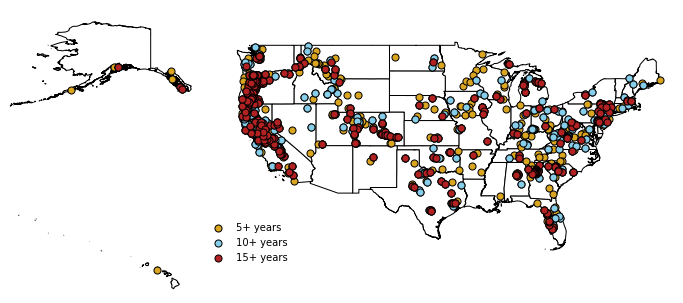

In [11]:
fig,ax = plt.subplots(1,figsize = (12,7))
gs = gridspec.GridSpec(2, 2, width_ratios=[1,2.5]) 
gs.update(hspace=0.0)
gs.update(wspace=0.0)
ax0 = plt.subplot(gs[:,1])
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[1,0])

size = 50

ax = ax0
state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.scatter(gagesII_long5.LNG_GAGE.values, gagesII_long5.LAT_GAGE.values,edgecolor='k',
          c='goldenrod',s=size, label = '5+ years')
ax.scatter(gagesII_long10.LNG_GAGE.values, gagesII_long10.LAT_GAGE.values,edgecolor='k',
          c='skyblue',s=size, label = '10+ years')
ax.scatter(gagesII_long15.LNG_GAGE.values, gagesII_long15.LAT_GAGE.values,edgecolor='k',
          c='firebrick',s=size, label = '15+ years')
ax.set_xlim(-130,-65)
ax.legend(frameon=False)
ax.set_ylim(22,50)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = ax1
state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.scatter(gagesII_long5.LNG_GAGE.values, gagesII_long5.LAT_GAGE.values,edgecolor='k',
          c='goldenrod',s=size)
ax.scatter(gagesII_long10.LNG_GAGE.values, gagesII_long10.LAT_GAGE.values,edgecolor='k',
          c='skyblue',s=size)
ax.scatter(gagesII_long15.LNG_GAGE.values, gagesII_long15.LAT_GAGE.values,edgecolor='k',
          c='firebrick',s=size)
ax.set_xlim(-180,-128)
ax.set_ylim(50,75)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

ax = ax2
state_outline.plot(facecolor='white',edgecolors = 'k', ax=ax)
ax.scatter(gagesII_long5.LNG_GAGE.values, gagesII_long5.LAT_GAGE.values,edgecolor='k',
          c='goldenrod',s=size)
ax.scatter(gagesII_long10.LNG_GAGE.values, gagesII_long10.LAT_GAGE.values,edgecolor='k',
          c='skyblue',s=size)
ax.scatter(gagesII_long15.LNG_GAGE.values, gagesII_long15.LAT_GAGE.values,edgecolor='k',
          c='firebrick',s=size)
ax.set_xlim(-180,-152)
ax.set_ylim(18,30)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')